In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#### load datasets

In [4]:
house_data = pd.read_excel("Clean_Data.xlsx")
house_data

,Date,Time,DateTime,System Setting,System Mode,Calendar Event,Program Mode,Cool Set Temp (C),Heat Set Temp (C),Current Temp (C),...,Thermostat Humidity (%RH),Thermostat Motion,Bedroom (C),Bedroom2,3rd floor landing (C),3rd floor landing2,3rd floor room (C),3rd floor room2,Basement (C),Basement2
0,2020-12-10,12:50:00,2020/12/10 12:50:00,heat,heatOff,auto,Home,21.0,21.0,21.3,...,30.0,1.0,21.6,0.0,20.9,0.0,21.0,0.0,22.8,0.0
1,2020-12-10,12:55:00,2020/12/10 12:55:00,heat,heatOff,auto,Home,21.0,21.0,21.1,...,32.0,1.0,21.6,0.0,20.9,0.0,20.9,0.0,22.7,1.0
2,2020-12-10,13:00:00,2020/12/10 13:00:00,heat,heatOff,auto,Home,21.0,21.0,20.9,...,32.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.7,1.0
3,2020-12-10,13:05:00,2020/12/10 13:05:00,heat,heatOff,auto,Home,21.0,21.0,20.7,...,33.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
4,2020-12-10,13:10:00,2020/12/10 13:10:00,heat,heatStage1On,auto,Home,21.0,21.0,20.6,...,33.0,1.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,2021-03-23,14:25:00,2021/3/23 14:25:00,heat,heatOff,NaN,Home,21.0,21.0,21.2,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.0,1.0
29672,2021-03-23,14:30:00,2021/3/23 14:30:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.1,0.0
29673,2021-03-23,14:35:00,2021/3/23 14:35:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0
29674,2021-03-23,14:40:00,2021/3/23 14:40:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0


In [5]:
enc = preprocessing.OneHotEncoder()

house_data = house_data.fillna(method = "bfill")
house_data.isnull().sum()

#### same as approch b, build new datasets

In [7]:
numerical_vars = ['Heat Set Temp (C)', 'Current Temp (C)', 'Current Humidity (%RH)', 'Outdoor Temp (C)','Thermostat Temperature (C)', 'Thermostat Humidity (%RH)']
sc = StandardScaler()
sc.fit(house_data[numerical_vars])
scalar_data = sc.transform(house_data[numerical_vars])

In [9]:
y_auxHeat = house_data['Heat Stage 1 (sec)'].to_numpy()
oe = OrdinalEncoder()
y_auxHeat = oe.fit_transform(y_auxHeat.reshape(-1, 1))

In [10]:
scaler_house_data = house_data[numerical_vars].copy()
scaler_house_data[numerical_vars] = scalar_data
scaler_house_data["Heat Stage 1"] = y_auxHeat

In [450]:
scaler_house_data

,Heat Set Temp (C),Current Temp (C),Current Humidity (%RH),Outdoor Temp (C),Thermostat Temperature (C),Thermostat Humidity (%RH),Heat Stage 1,fan
0,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0,0
1,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0,0
2,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0,0
3,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,9,9
4,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,20,20
...,...,...,...,...,...,...,...,...
29671,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0,0
29672,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0,0
29673,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0,0
29674,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0,0


##### use time-Lag build predictor. this function used to build time-lag datasets

In [55]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = data.shape[1]
    columns = data.columns
    df = pd.DataFrame(data)
    
    df_new = pd.DataFrame()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        for j in range(n_vars):
            df_new['var%d(t-%d)' % (j+1, i)] = df.shift(i)[columns[j]]
   
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        
        for j in range(n_vars):
            if i == 0:
                name = 'var%d(t)' % (j+1)
            else:
                name = 'var%d(t+%d)' % (j+1, i)
            df_new[name] = df.shift(-i)[columns[j]]
    
    if dropnan:
        df_new.dropna(inplace=True)
    return df_new

#### generate 30-minutes time-lag datasets

In [56]:
reframed = series_to_supervised(scaler_house_data, 6, 1)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
6,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,-0.796872,2.183776,20.0,0.0,-0.225278,2.183776,1.424799,-0.225278,2.183776,20.0
7,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,-0.225278,2.183776,20.0,0.0,0.917909,2.183776,1.424799,0.917909,2.183776,3.0
8,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,0.917909,2.183776,3.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
9,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,9.0,0.0,-1.368465,2.183776,...,1.489502,2.183776,0.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
10,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,20.0,0.0,-0.796872,2.183776,...,1.489502,2.183776,0.0,0.0,0.917909,2.183776,1.462204,0.917909,2.183776,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,3.204282,-0.098625,3.295068,3.204282,-0.098625,0.0,0.0,2.632689,-0.605825,...,2.061095,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.632689,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.061095,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


### target variable

In [61]:
y_auxHeat = reframed['var7(t)']
y_auxHeat = to_categorical(y_auxHeat)

In [62]:
y_auxHeat

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [1]:
test = np.argmax(y_auxHeat, axis = 1)

NameError: name 'np' is not defined

#### check target variable distribution

In [457]:
(unique, counts) = np.unique(test, return_counts = True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[    0, 15207],
       [    1,   382],
       [    2,   391],
       [    3,   409],
       [    4,   398],
       [    5,   389],
       [    6,   374],
       [    7,   387],
       [    8,   377],
       [    9,   404],
       [   10,   385],
       [   11,   392],
       [   12,   360],
       [   13,   360],
       [   14,   394],
       [   15,   388],
       [   16,   410],
       [   17,   420],
       [   18,   425],
       [   19,   369],
       [   20,  7049]], dtype=int64)

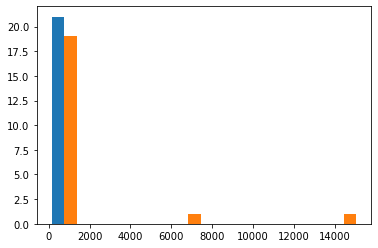

In [458]:
plt.hist(frequencies)
plt.show()

In [77]:
X = reframed.drop(labels = ['var7(t)'], axis = 1)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

In [79]:
test = np.argmax(y_train, axis = 1)

In [80]:
(unique, counts) = np.unique(test, return_counts = True)
frequencies = np.asarray((unique, counts)).T

In [70]:
X_train.shape,X_test.shape

((23736, 48), (5934, 48))

In [81]:
X_train = X_train.values
X_test = X_test.values

In [72]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [82]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 48))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 50, shuffle = True)

Epoch 1/50
371/371 [==============================] - 1s 3ms/step - loss: 1.4655 - accuracy: 0.6585 - val_loss: 1.0672 - val_accuracy: 0.7317
Epoch 2/50
371/371 [==============================] - 1s 2ms/step - loss: 0.9699 - accuracy: 0.7458 - val_loss: 0.9380 - val_accuracy: 0.7430
Epoch 3/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8993 - accuracy: 0.7519 - val_loss: 0.8979 - val_accuracy: 0.7438
Epoch 4/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8669 - accuracy: 0.7542 - val_loss: 0.8800 - val_accuracy: 0.7455
Epoch 5/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8505 - accuracy: 0.7542 - val_loss: 0.8665 - val_accuracy: 0.7455
Epoch 6/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8383 - accuracy: 0.7545 - val_loss: 0.8607 - val_accuracy: 0.7464
Epoch 7/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8290 - accuracy: 0.7546 - val_loss: 0.8494 - val_accuracy: 0.7484
Epoch 

In [469]:
classifier.summary()

Model: "sequential_225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_675 (Dense)            (None, 24)                1176      
_________________________________________________________________
dense_676 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_677 (Dense)            (None, 21)                525       
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_________________________________________________________________


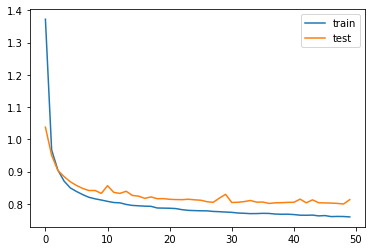

In [470]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.savefig("8.png")
plt.show()

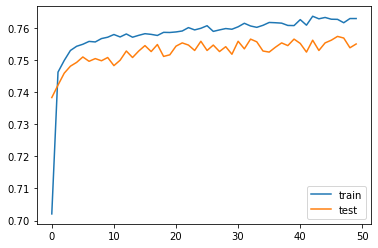

In [471]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.savefig("9.png")
plt.show()

In [100]:
y_predicted = classifier.predict(X_test)

In [101]:
y_predicted = np.argmax(y_predicted, axis = 1)
y_predicted

array([ 0,  0,  0, ...,  0,  0, 17], dtype=int64)

In [2]:
y_test = np.argmax(y_test, axis = 1)

NameError: name 'np' is not defined

In [97]:
test_sum = y_test.sum()*15
test_sum

671025

In [102]:
predicted_sum = y_predicted.sum()*15

In [103]:
predicted_sum

675930

#### caculate error percentage

In [104]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 0.7309712752878059 %


In [105]:
from sklearn.metrics import mean_absolute_error,f1_score,accuracy_score

In [106]:
y_train_predicted = classifier.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis = 1)
y_train = np.argmax(y_train, axis = 1)

In [482]:
f1_score(y_train, y_train_predicted, average = 'weighted')

0.7293476980033778

In [107]:
accuracy_score(y_train, y_train_predicted)

0.7660936973373779

In [108]:
mean_absolute_error(y_train, y_train_predicted)

0.9670542635658915

In [485]:
mean_absolute_error(y_test, y_predicted)

1.0389282103134478

In [109]:
accuracy_score(y_test, y_predicted)

0.754128749578699

In [110]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7166809430129301

### generate 60-minutes time-lag datasets

In [112]:
reframed_2 = series_to_supervised(scaler_house_data, 12, 1)
reframed_2

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var1(t-11),var2(t-11),var3(t-11),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
12,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,0.346315,2.183776,0.0,0.0,-0.225278,2.183776,1.462204,-0.225278,2.183776,0.0
13,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,-0.225278,2.183776,0.0,0.0,-0.225278,2.183776,1.462204,-0.225278,2.183776,0.0
14,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,-0.225278,2.183776,0.0,0.0,-0.796872,2.183776,1.443502,-0.796872,2.183776,17.0
15,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,9.0,0.0,-1.368465,2.183776,...,-0.796872,2.183776,17.0,0.0,-0.796872,2.183776,1.443502,-0.796872,2.183776,20.0
16,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,20.0,0.0,-0.796872,2.183776,...,-0.796872,2.183776,20.0,0.0,0.346315,2.183776,1.443502,0.346315,2.183776,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.145447,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


In [113]:
y_auxHeat = reframed_2['var7(t)']
y_auxHeat = to_categorical(y_auxHeat)
X.shape

(29670, 48)

In [114]:
X = reframed_2.drop(labels = ['var7(t)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

In [115]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_train.shape

(23731, 90)

In [116]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 90))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 50, shuffle = True)

Epoch 1/50
371/371 [==============================] - 1s 2ms/step - loss: 1.3780 - accuracy: 0.6916 - val_loss: 1.0414 - val_accuracy: 0.7350
Epoch 2/50
371/371 [==============================] - 1s 2ms/step - loss: 0.9670 - accuracy: 0.7462 - val_loss: 0.9479 - val_accuracy: 0.7438
Epoch 3/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8958 - accuracy: 0.7514 - val_loss: 0.8948 - val_accuracy: 0.7467
Epoch 4/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8654 - accuracy: 0.7533 - val_loss: 0.9024 - val_accuracy: 0.7421
Epoch 5/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8448 - accuracy: 0.7542 - val_loss: 0.8605 - val_accuracy: 0.7497
Epoch 6/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8324 - accuracy: 0.7550 - val_loss: 0.8591 - val_accuracy: 0.7482
Epoch 7/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8245 - accuracy: 0.7563 - val_loss: 0.8453 - val_accuracy: 0.7500
Epoch 

In [117]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                2184      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 21)                525       
Total params: 3,309
Trainable params: 3,309
Non-trainable params: 0
_________________________________________________________________


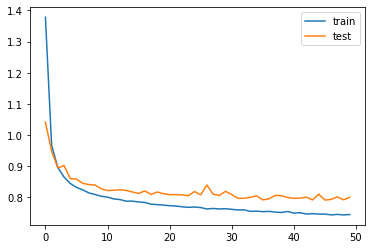

In [118]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.savefig("10.png")
plt.show()

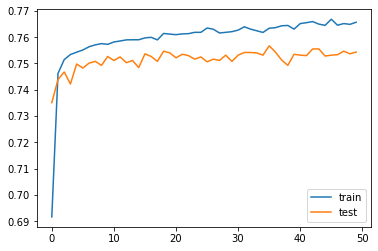

In [119]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.savefig("11.png")
plt.show()

In [120]:
y_predicted = classifier.predict(X_test)
y_predicted = np.argmax(y_predicted, axis = 1)
y_predicted

array([ 0, 20,  0, ..., 20,  0,  6], dtype=int64)

In [121]:
y_test = np.argmax(y_test, axis = 1)

In [123]:
test_sum = y_test.sum()*15
test_sum

653010

In [125]:
predicted_sum = y_predicted.sum()*15
predicted_sum

657480

In [126]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 0.6845224422290623 %


In [127]:
y_train_predicted = classifier.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis = 1)
y_train_predicted

array([ 0,  0, 20, ...,  0,  0,  0], dtype=int64)

In [128]:
y_train = np.argmax(y_train, axis = 1)

In [503]:
f1_score(y_train, y_train_predicted, average = 'weighted')

0.7306096239207006

In [129]:
mean_absolute_error(y_train, y_train_predicted)

1.0280224179343476

In [505]:
accuracy_score(y_train, y_train_predicted)

0.7667186380683494

In [506]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7148701513741895

In [507]:
mean_absolute_error(y_test, y_predicted)

1.0279790999494354

In [508]:
accuracy_score(y_test, y_predicted)

0.7539187594808697

#### Grid Search CV to tune parameters in 30-minutes time-lag model.

In [130]:
from sklearn.model_selection import cross_validate, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [132]:
reframed = series_to_supervised(scaler_house_data, 6, 1)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
6,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,-0.796872,2.183776,20.0,0.0,-0.225278,2.183776,1.424799,-0.225278,2.183776,20.0
7,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,-0.225278,2.183776,20.0,0.0,0.917909,2.183776,1.424799,0.917909,2.183776,3.0
8,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,0.917909,2.183776,3.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
9,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,9.0,0.0,-1.368465,2.183776,...,1.489502,2.183776,0.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
10,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,20.0,0.0,-0.796872,2.183776,...,1.489502,2.183776,0.0,0.0,0.917909,2.183776,1.462204,0.917909,2.183776,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,3.204282,-0.098625,3.295068,3.204282,-0.098625,0.0,0.0,2.632689,-0.605825,...,2.061095,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.632689,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.061095,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


In [133]:
y_auxHeat = reframed['var7(t)']
y_auxHeat = to_categorical(y_auxHeat).astype(float)

In [134]:
X = reframed.drop(labels = ['var7(t)'], axis = 1).astype(float)
X.shape

(29670, 48)

In [513]:
def build_classifier(optimizer):

    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 48))

    # Adding the second hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

    # Adding the output layer
    classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [514]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, nb_epoch = 20)

In [515]:
scoring = {'acc': 'accuracy'}

parameters = {'batch_size' : [10, 64,100],
              'epochs' : [10, 50],
              'optimizer' : ['adam', 'rmsprop']}

In [516]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = scoring,
                           refit = False,
                           cv = 10)

In [517]:
grid_search.fit(X, y_auxHeat)

Epoch 1/10
2671/2671 [==============================] - 4s 1ms/step - loss: 1.0158 - accuracy: 0.7367
Epoch 2/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.8485 - accuracy: 0.7550
Epoch 3/10
2671/2671 [==============================] - 4s 2ms/step - loss: 0.8195 - accuracy: 0.7571
Epoch 4/10
2671/2671 [==============================] - 6s 2ms/step - loss: 0.8068 - accuracy: 0.7569
Epoch 5/10
2671/2671 [==============================] - 5s 2ms/step - loss: 0.7976 - accuracy: 0.7588
Epoch 6/10
2671/2671 [==============================] - 5s 2ms/step - loss: 0.7917 - accuracy: 0.7584
Epoch 7/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7842 - accuracy: 0.7620
Epoch 8/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7826 - accuracy: 0.7604
Epoch 9/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7795 - accuracy: 0.7612
Epoch 10/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.774

c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _sco

Epoch 1/10
2671/2671 [==============================] - 4s 1ms/step - loss: 1.0170 - accuracy: 0.7402
Epoch 2/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.8400 - accuracy: 0.7604
Epoch 3/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.8104 - accuracy: 0.7616
Epoch 4/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7995 - accuracy: 0.7615
Epoch 5/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.7907 - accuracy: 0.7626
Epoch 6/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.7857 - accuracy: 0.7629
Epoch 7/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.7804 - accuracy: 0.7633
Epoch 8/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7765 - accuracy: 0.7632
Epoch 9/10
2671/2671 [==============================] - 4s 2ms/step - loss: 0.7745 - accuracy: 0.7646
Epoch 10/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.772

c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _sco

Epoch 1/10
2671/2671 [==============================] - 4s 1ms/step - loss: 1.0253 - accuracy: 0.7416
Epoch 2/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.8656 - accuracy: 0.7549
Epoch 3/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.8358 - accuracy: 0.7562
Epoch 4/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.8226 - accuracy: 0.7575
Epoch 5/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.8113 - accuracy: 0.7574
Epoch 6/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.8041 - accuracy: 0.7607
Epoch 7/10
2671/2671 [==============================] - 3s 1ms/step - loss: 0.7969 - accuracy: 0.7602
Epoch 8/10
2671/2671 [==============================] - 4s 2ms/step - loss: 0.7922 - accuracy: 0.7603
Epoch 9/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7880 - accuracy: 0.7604
Epoch 10/10
2671/2671 [==============================] - 5s 2ms/step - loss: 0.784

c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\hongyliu\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _sco

Epoch 1/10
2671/2671 [==============================] - 4s 1ms/step - loss: 1.0295 - accuracy: 0.7386
Epoch 2/10
2671/2671 [==============================] - 4s 2ms/step - loss: 0.8590 - accuracy: 0.7547
Epoch 3/10
2671/2671 [==============================] - 4s 2ms/step - loss: 0.8336 - accuracy: 0.7562
Epoch 4/10
2671/2671 [==============================] - 6s 2ms/step - loss: 0.8184 - accuracy: 0.7569
Epoch 5/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.8070 - accuracy: 0.7581
Epoch 6/10
2671/2671 [==============================] - 4s 2ms/step - loss: 0.8029 - accuracy: 0.7584
Epoch 7/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7960 - accuracy: 0.7588
Epoch 8/10
2671/2671 [==============================] - 4s 1ms/step - loss: 0.7911 - accuracy: 0.7590
Epoch 9/10
1251/2671 [=============>................] - ETA: 5s - loss: 0.7886 - accuracy: 0.7575

KeyboardInterrupt: 

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.get_params

In [ ]:
grid_search_results = pd.DataFrame(grid_search.cv_results_, columns = list(grid_search.cv_results_.keys()))
grid_search_results

### Cross Validation

In [156]:
def build_classifier(ac_func):

    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = ac_func, input_dim = 48))

    # Adding the second hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = ac_func))

    # Adding the output layer
    classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [165]:
ac_funcs = ['relu', 'sigmoid', 'tanh']
ac_funcs_score_time = []
ac_funcs_acc = []
ac_funcs_f1 = []

In [140]:
X = X.astype(float)
y_auxHeat = y_auxHeat.astype(float)

In [157]:
classifier = KerasClassifier(build_fn = build_classifier,ac_func =ac_funcs[0],  batch_size = 64, nb_epoch = 50)

In [158]:
scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, cv = 10)
scores

47/47 [==============================] - 0s 2ms/step - loss: 0.7986 - accuracy: 0.8018


{'fit_time': array([1.5249517 , 1.92585731, 1.74932075, 1.67552781, 1.46109891,
        1.5797708 , 1.29054546, 2.15025115, 1.31348801, 1.2895391 ]),
 'score_time': array([0.37397814, 0.4986701 , 0.32313728, 0.33310866, 0.33811545,
        0.32413459, 0.31714249, 0.32414579, 0.32413387, 0.31217027]),
 'test_score': array([0.70205593, 0.68385577, 0.71284127, 0.72901922, 0.71284127,
        0.74047858, 0.75193799, 0.77856421, 0.80148298, 0.80182004])}

In [159]:
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_score'])
#ac_funcs_f1.append(scores['test_f1_weighted'])

In [160]:
X.shape,y_auxHeat.shape

((29670, 48), (29670, 21))

In [166]:
classifier = KerasClassifier(build_fn = build_classifier,ac_func = ac_funcs[1], batch_size = 64, nb_epoch = 50)


scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, cv = 10)
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_score'])

47/47 [==============================] - 0s 1ms/step - loss: 1.2625 - accuracy: 0.6633


In [174]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 64, nb_epoch = 50)

scoring = {'acc': 'accuracy',
           }

scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, cv = 10)
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_score'])

47/47 [==============================] - 0s 1ms/step - loss: 0.7700 - accuracy: 0.8052


In [175]:
ac_funcs_acc

[array([0.45837545, 0.47724974, 0.4967981 , 0.52612066, 0.44017527,
        0.43006405, 0.42938995, 0.57398045, 0.62992924, 0.66329628]),
 array([0.7074486 , 0.68115944, 0.71587461, 0.72767103, 0.72227842,
        0.7377823 , 0.73980451, 0.77721602, 0.80080891, 0.80417931]),
 array([0.71452647, 0.68082237, 0.71149307, 0.71890801, 0.72396362,
        0.72868216, 0.73677117, 0.77923828, 0.79676443, 0.80519044])]

In [176]:
acc_df = pd.DataFrame(ac_funcs_acc)
acc_df = acc_df.T

In [177]:
acc_df = acc_df.rename(columns = {0:'ReLu', 1:'Sigmoid', 2:'Tanh'})

In [178]:
acc_df

,ReLu,Sigmoid,Tanh
0,0.458375,0.707449,0.714526
1,0.477250,0.681159,0.680822
2,0.496798,0.715875,0.711493
3,0.526121,0.727671,0.718908
4,0.440175,0.722278,0.723964
5,0.430064,0.737782,0.728682
6,0.429390,0.739805,0.736771
7,0.573980,0.777216,0.779238
8,0.629929,0.800809,0.796764
9,0.663296,0.804179,0.805190


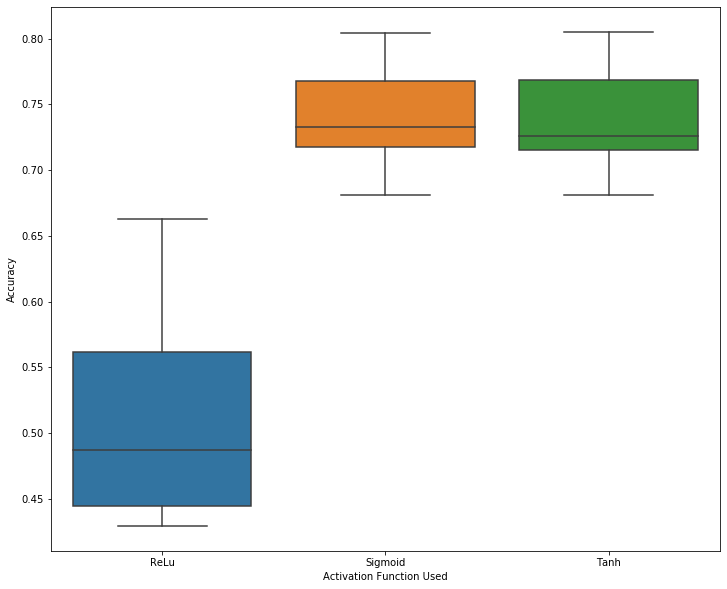

In [179]:
plt.figure(figsize = (12, 10))
ax = sns.boxplot(data = acc_df)
ax.set(ylabel = "Accuracy", xlabel = "Activation Function Used")
plt.savefig("12.png")

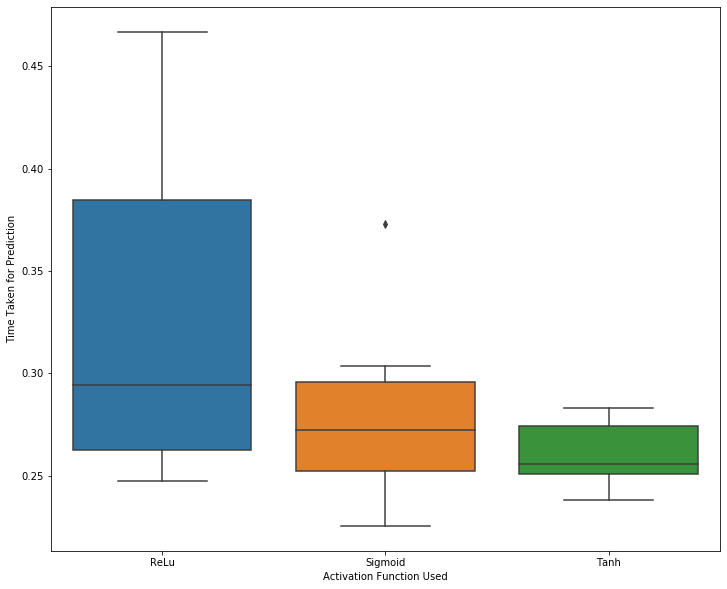

In [180]:
time_df = pd.DataFrame(ac_funcs_score_time)
time_df = time_df.T

time_df = time_df.rename(columns = {0:'ReLu', 1:'Sigmoid', 2:'Tanh'})

plt.figure(figsize = (12, 10))
ax = sns.boxplot(data = time_df)
ax.set(ylabel = "Time Taken for Prediction", xlabel = "Activation Function Used")
plt.savefig("14.png")